## Modality-specific object selectivity
This code examines the modality bias of PER single neurons. That is, neurons were classified into visually-biased, auditorily-biased, or unbiased categories. Temporal characteristics were compared between the categories

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
import time

import h5py

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
mother_path = Path('D:/Multi-modal project/')

save_path = mother_path / 'analysis' / 'result' / '5. Modality-specific object selectivity'
os.makedirs(save_path,exist_ok=True)

fig_path = mother_path / 'analysis' / 'result' / 'figures'
os.makedirs(fig_path,exist_ok=True)

### Parameter setting

In [4]:
gauss_sigma = 2

# colors for multimodal, vis-only, aud-only conditions
color = ['tab:blue','tab:red','tab:gray']
color2 = ['tab:cyan','tab:pink','tab:gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [5]:
# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-07-10'
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-07-10'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-07-10_multiple_regression_result.hdf5','r')

# load performance (correctness) data
perf_data = pd.read_csv(mother_path / 'analysis' / 'result' / 'correctness.csv')

In [6]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [7]:
df = h5_to_df(f2)
df = df[(df['region']=='PER')&(df['response cell']==0)]
df.reset_index(inplace=True,drop=True)

for key in df['key']:  
    
    df.loc[df['key']==key,'pref_obj'] = f[key].attrs['preferred object']
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = f[key].attrs['peak selectivity time']
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_index'] = f[key].attrs['selectivity index']
    df.loc[df['key']==key,'BG'] = f[key].attrs['BG']
    
    # load performance (correctness) data
    rat = 'LE'+str(df.loc[df['key']==key,'rat'].item())
    ss = int(df.loc[df['key']==key,'session'].item())    
    df.loc[df['key']==key,'M_corr'] = perf_data.loc[(perf_data.rat==rat) & (perf_data.session==ss), 'M'].item()
    df.loc[df['key']==key,'V_corr'] = perf_data.loc[(perf_data.rat==rat) & (perf_data.session==ss), 'V'].item()
    df.loc[df['key']==key,'A_corr'] = perf_data.loc[(perf_data.rat==rat) & (perf_data.session==ss), 'A'].item()
    df.loc[df['key']==key,'C_corr'] = perf_data.loc[(perf_data.rat==rat) & (perf_data.session==ss), 'C'].item()
    
    if f[key].attrs['preferred object'] == 'Boy':
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][3]
    else:
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][3]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1        

### Classifying visual, auditory, and unbiased neurons

In [8]:
# classification based on permutation test (shuffling)
for i in range(len(df)):
    k = df.loc[i,'key']
    beta_diff = df.loc[i,'coef_pref_image']-df.loc[i,'coef_pref_sound']
    if df.loc[i,'pref_obj']=='Boy':
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,0],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,1])
    else:
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,2],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,3])
    visual_crit = np.percentile(beta_diff_shuffle,97.5)
    auditory_crit = np.percentile(beta_diff_shuffle,2.5)
    
    if beta_diff > visual_crit:
        df.loc[i,'Category'] = 'visual'
    elif beta_diff < auditory_crit:
        df.loc[i,'Category'] = 'auditory'
    else:
        df.loc[i,'Category'] = 'unbiased'

In [9]:
#df.to_csv(save_path / f'{today}_modality_specific.csv')

In [10]:
x = [sum(df['Category']=='visual'), sum(df['Category']=='auditory'), sum(df['Category']=='unbiased')]

print(f'Visual cell: {x[0]} / {np.sum(x)}')
print(f'Auditory cell: {x[1]} / {np.sum(x)}')
print(f'Unbiased cell: {x[2]} / {np.sum(x)}')

Visual cell: 21 / 149
Auditory cell: 27 / 149
Unbiased cell: 101 / 149


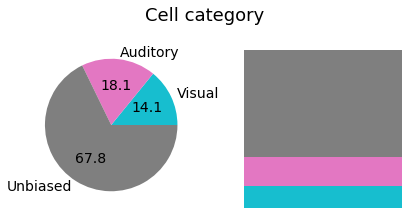

In [52]:
# proportion plot

fig,ax = plt.subplots(1,2,figsize=(6,3))

fig.suptitle('Cell category', fontsize=18)
ax[0].pie(x,colors=color2,labels=['Visual','Auditory','Unbiased'],autopct='%.1f',textprops={'fontsize':14});
ax[1].axis('off')
prev_data = 0
for i in range(3):
    ax[1].bar(1, height = x[i], bottom=prev_data, color=color2[i])
    prev_data += x[i]

plt.tight_layout()
#plt.savefig(fig_path / 'cell_porportion_pie_bar.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'cell_porportion_pie_bar.svg')

### Beta coefficients of all object cells

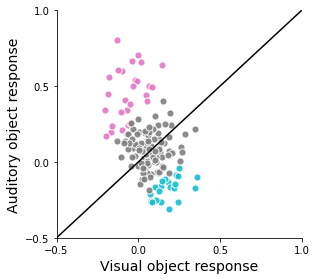

In [53]:
fig,ax = plt.subplots(figsize=(4.5,4))

gs = fig.add_gridspec(2,2, width_ratios=(4,1), height_ratios=(1,4))

#ax.scatter(df['coef_pref_image'],df['coef_pref_sound'], 
#           c = df['peak_selectivity_time_range'], cmap = 'viridis')
#norm = mpl.colors.Normalize(vmin=0,vmax=9)
#colormapping = mpl.cm.ScalarMappable(norm=norm,cmap=mpl.cm.viridis)
#fig.colorbar(colormapping, ax=plt.gca())

cat = ['visual','auditory','unbiased']
colors = ['tab:cyan','tab:pink','tab:gray']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'coef_pref_image']
    y = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax.scatter(x, y, facecolors=colors[c],edgecolors='white',alpha=0.9, s=50)

ax.plot(np.arange(-1,2.1,0.5),np.arange(-1,2.1,0.5),color='black')
ax.set_xticks(np.arange(-1,2.1,0.5));
ax.set_yticks(np.arange(-1,2.1,0.5));
ax.set_xlim([-0.5,1])
ax.set_ylim([-0.5,1])

ax.set_xlabel('Visual object response',fontsize=14);
ax.set_ylabel('Auditory object response',fontsize=14);

plt.tight_layout()

#plt.savefig(fig_path / 'image_sound_scatter.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'image_sound_scatter.svg')

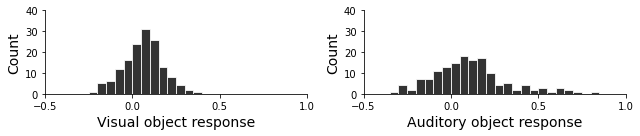

In [54]:
fig,ax = plt.subplots(1,2,figsize=(9,2))

x = ['coef_pref_image', 'coef_pref_sound']
xlabel = ['Visual object response', 'Auditory object response']

for i in range(2):
    ax[i].hist(df[x[i]], color='black', bins=np.arange(-0.5,1,0.05), alpha=0.8, ec='white');
    ax[i].set_xlabel(xlabel[i], fontsize=14);
    ax[i].set_xticks(np.arange(-0.5,1.5,0.5));
    ax[i].set_xlim([-0.5,1])
    ax[i].set_ylabel('Count', fontsize=14);
    ax[i].set_yticks(np.arange(0,45,10));

plt.tight_layout()
#plt.savefig(fig_path / 'image_sound_hist.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'image_sound_hist.svg')

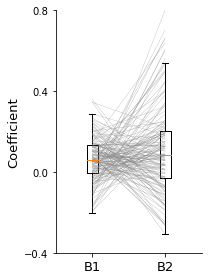

In [56]:
fig,ax = plt.subplots(figsize=(3,4))

ax.boxplot([df['coef_pref_image'], df['coef_pref_sound']], showfliers=False,);
for i in range(len(df)):
    ax.plot([1,2], [df.loc[i,'coef_pref_image'], df.loc[i,'coef_pref_sound']],
            linewidth=0.2, color='tab:gray')
ax.set_xticklabels(['B1', 'B2'], fontsize=13);
ax.set_yticks(np.arange(-0.4,0.9,0.4));
ax.set_ylim([-0.4,0.8])
ax.set_ylabel('Coefficient', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'duration_box_object_response.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'b1_b2_boxplot.svg')

In [57]:
pg.wilcoxon(df['coef_pref_image'],df['coef_pref_sound'])

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,4794.0,two-sided,0.132888,-0.142013,0.444484


### Peak selectivity time and beta coefficients

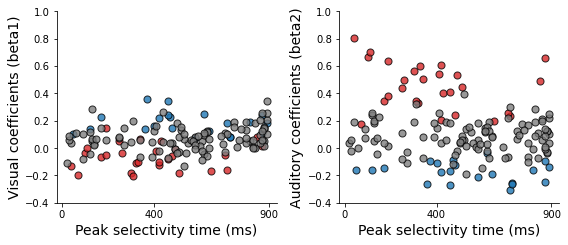

In [58]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))

cat = ['visual','auditory','unbiased']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'peak_selectivity_time']
    y = df.loc[df['Category']==cat[c],'coef_pref_image']        
    y2 = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax[0].scatter(x, y, facecolors=color[c], edgecolors='k', alpha=0.8, s=50)
    ax[1].scatter(x, y2, facecolors=color[c], edgecolors='k', alpha=0.8, s=50)

ylabel = ['Visual coefficients (beta1)', 'Auditory coefficients (beta2)']
for i in range(2):
    ax[i].set_xticks([0,400,900]);
    ax[i].set_xlabel('Peak selectivity time (ms)', fontsize=14);
    ax[i].set_yticks(np.arange(-0.4,1.2,0.2));
    ax[i].set_ylabel(ylabel[i], fontsize=14);

plt.tight_layout()
#plt.savefig(fig_path / 'coef_time_scatter.png', dpi=300,facecolor='white')

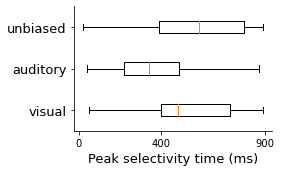

In [27]:
fig,ax = plt.subplots(figsize=(4,2.5))

x = ['visual','auditory','unbiased']
y = [df.loc[df['Category']==c,'peak_selectivity_time'] for c in x]
ax.boxplot(y, vert=False);
ax.set_yticklabels(x, fontsize=13);
ax.set_xticks([0, 400, 900]);
ax.set_xlabel('Peak selectivity time (ms)', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'category_time_boxplot.png', dpi=300,facecolor='white')

In [36]:
print('Kruskal-Wallis test')
print(pg.kruskal(data=df, dv='peak_selectivity_time', between='Category'))
print('====================================================')

import scikit_posthocs as sp

x = ['visual','auditory','unbiased']
y = [df.loc[df['Category']==c,'peak_selectivity_time'] for c in x]
kruskal_posthoc = sp.posthoc_dunn(y, p_adjust = 'simes-hochberg')
print('Post-hoc using dunn test')
print(kruskal_posthoc)

Kruskal-Wallis test
           Source  ddof1         H     p-unc
Kruskal  Category      2  9.124335  0.010439
Post-hoc using dunn test
          1         2         3
1  1.000000  0.090861  0.772552
2  0.090861  1.000000  0.007921
3  0.772552  0.007921  1.000000


In [13]:
x = ['visual','auditory']
y = [df.loc[df['Category']==c,'peak_selectivity_time'] for c in x]
pg.mwu(y[0], y[1])

,U-val,alternative,p-val,RBC,CLES
MWU,388.5,two-sided,0.029796,-0.37037,0.685185


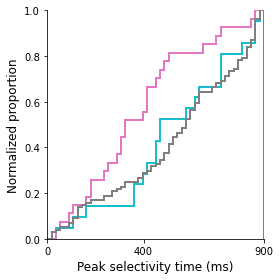

In [12]:
fig,ax = plt.subplots(figsize=(4,4))

x = ['visual','auditory','unbiased']
y = [df.loc[df['Category']==c,'peak_selectivity_time'] for c in x]

for i in range(3):
    ax.hist(y[i], range=(0,900), bins=50, cumulative=1, histtype='step', density=True, 
        edgecolor=color2[i], linewidth=2);

ax.set_ylim([0,1])
ax.set_xticks([0,400,900])
ax.set_xlim([0,900])
ax.set_ylabel('Normalized proportion',fontsize=12);
ax.set_xlabel('Peak selectivity time (ms)',fontsize=12);

plt.tight_layout()

#plt.savefig(fig_path / 'peak_time_object_response.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'peak_time_modality_cateogry_CDF.svg')

In [15]:
s1, p1 = stats.kstest(y[0], y[1])
s2, p2 = stats.kstest(y[0], y[2])
s3, p3 = stats.kstest(y[1], y[2])

print('K-S test for peak selectivity time')
print(f'Visual vs. Auditory: D = {s1} / p = {p1*3}')
print(f'Visual vs. Unbiased: D = {s2} / p = {p2*3}')
print(f'Auditory vs. Unbiased: D = {s3} / p = {p3*3}')

K-S test for peak selectivity time
Visual vs. Auditory: D = 0.37566137566137564 / p = 0.15918072574645725
Visual vs. Unbiased: D = 0.17727487034417727 / p = 1.7344001796583204
Auditory vs. Unbiased: D = 0.4213421342134213 / p = 0.0018904316246880493


### Recording sites and beta coefficients

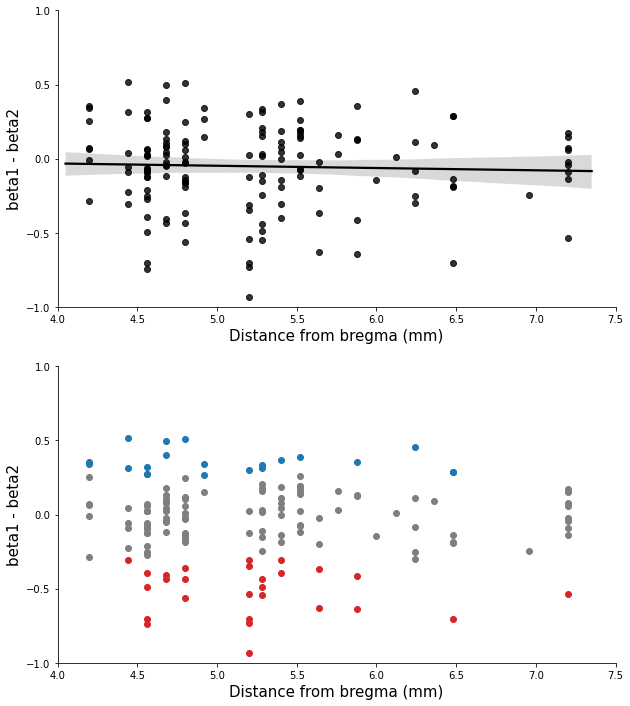

In [17]:
df.loc[df.BG==7.24,'BG'] = 7.2
df['coef_diff'] = df['coef_pref_image']-df['coef_pref_sound']

cat = ['visual','auditory','unbiased']
marker = ['s', '^', 'o']

fig,ax = plt.subplots(2,1,figsize=(10,12))

sns.regplot(x='BG', y='coef_diff', data=df, ax=ax[0], truncate=False, color='black')
ax[0].set_yticks(np.arange(-1, 1.1, 0.5));
ax[0].set_ylim([-1, 1])
ax[0].set_ylabel('beta1 - beta2',fontsize=15)
#ax[0].set_xticks(np.sort(df['BG'].unique()))
#ax[0].set_xticklabels(np.sort(df['BG'].unique())*-1)
ax[0].set_xticks(np.arange(4,8,0.5))
ax[0].set_xlim([4,7.5])
#ax[0].tick_params(axis='x',labelrotation=45)
ax[0].set_xlabel('Distance from bregma (mm)',fontsize=15);

for i in range(len(df)):
    category = df.loc[i, 'Category']
    color_index = cat.index(category)
    ax[1].scatter(x=df.loc[i, 'BG'], y=df.loc[i, 'coef_diff'], color=color[color_index])
ax[1].set_yticks(np.arange(-1, 1.1, 0.5));
ax[1].set_ylim([-1, 1])
ax[1].set_ylabel('beta1 - beta2',fontsize=15)
#ax[1].set_xticks(np.sort(df['BG'].unique()))
#ax[1].set_xticklabels(np.sort(df['BG'].unique())*-1)
ax[1].set_xticks(np.arange(4,8,0.5))
ax[1].set_xlim([4,7.5])
#ax[1].tick_params(axis='x',labelrotation=45)
ax[1].set_xlabel('Distance from bregma (mm)',fontsize=15);

#plt.savefig(fig_path / 'anatomy_category_scatter.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'anatomy_category_scatter.svg')

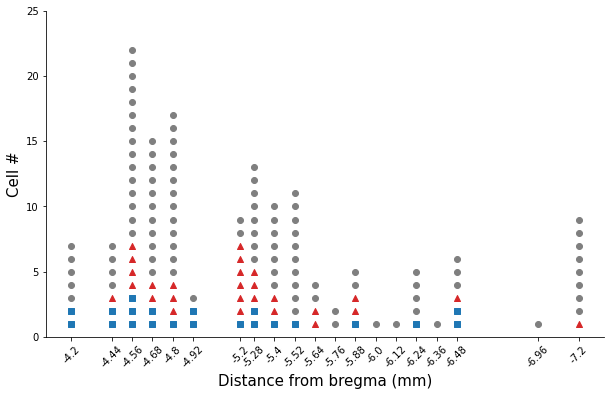

In [22]:
bg_dict = {bg : 1 for bg in np.sort(df['BG'].unique())}

fig,ax = plt.subplots(figsize=(10,6))

cat = ['visual','auditory','unbiased']
marker = ['s', '^', 'o']

for i in range(3):
    df_cat = df[df['Category']==cat[i]]
    df_cat.reset_index(inplace=True, drop=True)
    for j in range(len(df_cat)):
        bg = df_cat.loc[j,'BG']
        ax.scatter(bg, bg_dict[bg], color=color[i], marker=marker[i])
        bg_dict[bg] += 1
ax.set_yticks(np.arange(0,30,5));
ax.set_ylabel('Cell #',fontsize=15)
ax.set_xticks(np.sort(df['BG'].unique()))
ax.set_xticklabels(np.sort(df['BG'].unique())*-1)
ax.tick_params(axis='x',labelrotation=45)
ax.set_xlabel('Distance from bregma (mm)',fontsize=15);

#plt.savefig(fig_path / 'anatomy_category_scatter.png', dpi=300,facecolor='white')

### Beta coefficients and performance

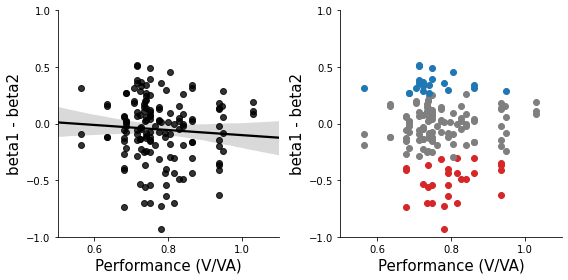

                            OLS Regression Results                            
Dep. Variable:              coef_diff   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7361
Date:                Thu, 02 Nov 2023   Prob (F-statistic):              0.392
Time:                        15:02:28   Log-Likelihood:                -24.283
No. Observations:                 149   AIC:                             52.57
Df Residuals:                     147   BIC:                             58.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1230      0.204     

In [10]:
# visual performance

cat = ['visual','auditory','unbiased']
df['coef_diff'] = df['coef_pref_image']-df['coef_pref_sound']
df['V_corr_relative'] = df['V_corr']/df['M_corr']

fig,ax = plt.subplots(1,2, figsize=(8,4))

ax[0].set_yticks(np.arange(-1, 1.1, 0.5));
ax[0].set_ylim([-1, 1])
ax[0].set_xticks(np.arange(0,1.3,0.2))
ax[0].set_xlim([0.5,1.1])
sns.regplot(x='V_corr_relative', y='coef_diff', data=df, ax=ax[0], truncate=False, color='black')
ax[0].set_ylabel('beta1 - beta2',fontsize=15)
ax[0].set_xlabel('Performance (V/VA)',fontsize=15);

for i in range(len(df)):
    category = df.loc[i, 'Category']
    color_index = cat.index(category)
    ax[1].scatter(x=df.loc[i, 'V_corr_relative'], y=df.loc[i, 'coef_diff'], color=color[color_index])
ax[1].set_yticks(np.arange(-1, 1.1, 0.5));
ax[1].set_ylim([-1, 1])
ax[1].set_xticks(np.arange(0,1.3,0.2))
ax[1].set_xlim([0.5,1.1])
ax[1].set_ylabel('beta1 - beta2',fontsize=15)
ax[1].set_xlabel('Performance (V/VA)',fontsize=15);


plt.tight_layout()
plt.savefig(fig_path / 'svg' / 'coef_diff_visual_perf.svg')
plt.show()

#######################################################################################

# linear regression result
y1 = df['coef_diff']
x1 = df['V_corr_relative']
lr1 = sm.OLS(y1, sm.add_constant(x1)).fit()
print(lr1.summary())

In [12]:
stats.pearsonr(y1, x1)

(-0.07058688701148741, 0.39231092501530873)

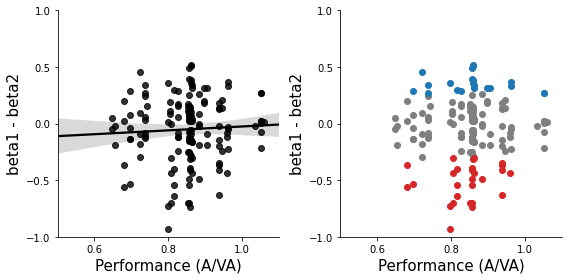

                            OLS Regression Results                            
Dep. Variable:              coef_diff   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4372
Date:                Thu, 02 Nov 2023   Prob (F-statistic):              0.510
Time:                        15:04:06   Log-Likelihood:                -24.434
No. Observations:                 149   AIC:                             52.87
Df Residuals:                     147   BIC:                             58.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1961      0.221     

In [13]:
# auditory performance

cat = ['visual','auditory','unbiased']
df['coef_diff'] = df['coef_pref_image']-df['coef_pref_sound']
df['A_corr_relative'] = df['A_corr']/df['M_corr']

fig,ax = plt.subplots(1,2, figsize=(8,4))

ax[0].set_yticks(np.arange(-1, 1.1, 0.5));
ax[0].set_ylim([-1, 1])
ax[0].set_xticks(np.arange(0,1.3,0.2))
ax[0].set_xlim([0.5,1.1])
sns.regplot(x='A_corr_relative', y='coef_diff', data=df, ax=ax[0], truncate=False, color='black')
ax[0].set_ylabel('beta1 - beta2',fontsize=15)
ax[0].set_xlabel('Performance (A/VA)',fontsize=15);

for i in range(len(df)):
    category = df.loc[i, 'Category']
    color_index = cat.index(category)
    ax[1].scatter(x=df.loc[i, 'A_corr_relative'], y=df.loc[i, 'coef_diff'], color=color[color_index])
ax[1].set_yticks(np.arange(-1, 1.1, 0.5));
ax[1].set_ylim([-1, 1])
ax[1].set_xticks(np.arange(0,1.3,0.2))
ax[1].set_xlim([0.5,1.1])
ax[1].set_ylabel('beta1 - beta2',fontsize=15)
ax[1].set_xlabel('Performance (A/VA)',fontsize=15);


plt.tight_layout()
#plt.savefig(fig_path / 'svg' / 'coef_diff_auditory_perf.svg')
plt.show()

#######################################################################################

# linear regression result
y1 = df['coef_diff']
x1 = df['A_corr_relative']
lr1 = sm.OLS(y1, sm.add_constant(x1)).fit()
print(lr1.summary())

In [14]:
stats.pearsonr(y1, x1)

(0.054453440219825795, 0.5095229603793574)

### Beta coefficients for non-preferred object

In [9]:
# classification based on beta coefficients for non-preferred object condition
for i in range(len(df)):
    k = df.loc[i,'key']
    beta_diff = df.loc[i,'coef_nonpref_image']-df.loc[i,'coef_nonpref_sound']
    if df.loc[i,'pref_obj']=='Boy':
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,2],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,3])
    else:
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,0],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,1])
    visual_crit = np.percentile(beta_diff_shuffle,97.5)
    auditory_crit = np.percentile(beta_diff_shuffle,2.5)
    
    if beta_diff > visual_crit:
        df.loc[i,'Category_nonpref'] = 'visual'
    elif beta_diff < auditory_crit:
        df.loc[i,'Category_nonpref'] = 'auditory'
    else:
        df.loc[i,'Category_nonpref'] = 'others'

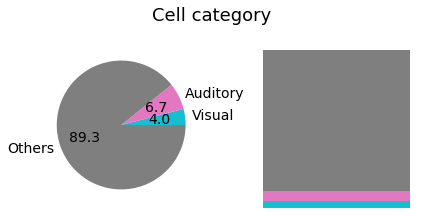

In [31]:
# proportion plot

x = df.groupby('Category_nonpref').size().reindex(['visual', 'auditory', 'others'])

fig,ax = plt.subplots(1,2,figsize=(6,3))

fig.suptitle('Cell category', fontsize=18)
ax[0].pie(x,colors=color2,labels=['Visual','Auditory','Others'],autopct='%.1f',textprops={'fontsize':14});
ax[1].axis('off')
prev_data = 0
for i in range(3):
    ax[1].bar(1, height = x[i], bottom=prev_data, color=color2[i])
    prev_data += x[i]

plt.tight_layout()
#plt.savefig(fig_path / 'cell_porportion_pie_bar.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'nonprefer_cell_porportion_pie_bar.svg')

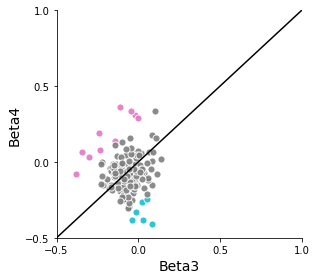

In [30]:
fig,ax = plt.subplots(figsize=(4.5,4))

gs = fig.add_gridspec(2,2, width_ratios=(4,1), height_ratios=(1,4))

cat = ['visual','auditory','others']
colors = ['tab:cyan','tab:pink','tab:gray']
for c in range(3):
    x = df.loc[df['Category_nonpref']==cat[c],'coef_nonpref_image']
    y = df.loc[df['Category_nonpref']==cat[c],'coef_nonpref_sound']
    ax.scatter(x, y, facecolors=colors[c],edgecolors='white',alpha=0.9, s=50)

ax.plot(np.arange(-1,2.1,0.5),np.arange(-1,2.1,0.5),color='black')
ax.set_xticks(np.arange(-0.5,1.1,0.5));
ax.set_yticks(np.arange(-0.5,1.1,0.5));
ax.set_xlim([-0.5,1])
ax.set_ylim([-0.5,1])

ax.set_xlabel('Beta3',fontsize=14);
ax.set_ylabel('Beta4',fontsize=14);

plt.tight_layout()

#plt.savefig(fig_path / 'image_sound_scatter.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'nonprefer_image_sound_scatter.svg')

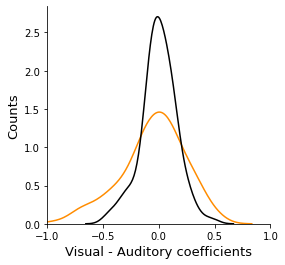

Kurtosis for preferred beta coefficients = 0.14
Kurtosis for nonpreferred beta coefficients = 0.83
KstestResult(statistic=0.19463087248322147, pvalue=0.006956560266936682)


In [29]:
# comparing beta coefficients between preferred object and nonpreferred object

fig,ax = plt.subplots(figsize=(4,4))

sns.kdeplot(df['coef_pref_image']-df['coef_pref_sound'], color='darkorange', ax=ax)
sns.kdeplot(df['coef_nonpref_image']-df['coef_nonpref_sound'], color='black',ax=ax);
ax.set_xticks(np.arange(-1,1.1,0.5))
ax.set_xlim([-1, 1])
#ax.set_yticks(np.arange(0,51,10))
ax.set_xlabel('Visual - Auditory coefficients', fontsize=13)
ax.set_ylabel('Counts', fontsize=13)
#plt.savefig(fig_path / 'image_sound_scatter.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'pref_nonpref_beta_hist.svg')
plt.show()


pref_kurtosis = stats.kurtosis(df['coef_pref_image']-df['coef_pref_sound'])
nonpref_kurtosis = stats.kurtosis(df['coef_nonpref_image']-df['coef_nonpref_sound'])

print(f'Kurtosis for preferred beta coefficients = {pref_kurtosis:.2f}')
print(f'Kurtosis for nonpreferred beta coefficients = {nonpref_kurtosis:.2f}')

print('============================================================================')

ks_result = stats.ks_2samp(df['coef_pref_image']-df['coef_pref_sound'], df['coef_nonpref_image']-df['coef_nonpref_sound'])
print(ks_result)

### Selectivity duration and modality-specific categories

In [20]:
lr_v = sm.OLS(df['coef_pref_image'],sm.add_constant(df['selectivity_duration'])).fit()
lr_a = sm.OLS(df['coef_pref_sound'],sm.add_constant(df['selectivity_duration'])).fit()

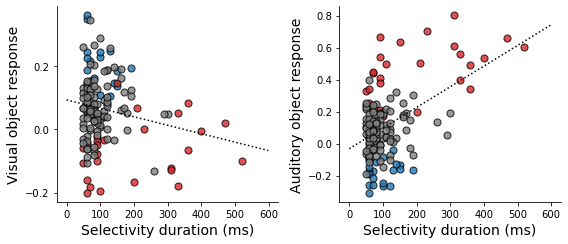

In [21]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))

cat = ['visual','auditory','unbiased']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'selectivity_duration']
    y = df.loc[df['Category']==cat[c],'coef_pref_image']
    y2 = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax[0].scatter(x, y, facecolors=colors[c], edgecolors='k', alpha=0.8, s=50)
    ax[1].scatter(x, y2, facecolors=colors[c], edgecolors='k', alpha=0.8, s=50)
    
ylabel = ['Visual object response', 'Auditory object response']
for i in range(2):
    ax[i].set_xticks(np.arange(0,700,100));
    ax[i].set_xlabel('Selectivity duration (ms)', fontsize=14);
    ax[i].set_yticks(np.arange(-0.4,1.2,0.2));
    ax[i].set_ylabel(ylabel[i], fontsize=14);
    
x = np.arange(0,600,1)
ax[0].plot(x, x*lr_v.params[1]+lr_v.params[0], linestyle=':', color='black')
ax[1].plot(x, x*lr_a.params[1]+lr_a.params[0], linestyle=':', color='black')

plt.tight_layout()
#plt.savefig(fig_path / 'duration_coef_scatter.png', dpi=300,facecolor='white')

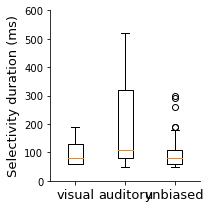

In [69]:
fig,ax = plt.subplots(figsize=(3,3))

x = ['visual','auditory','unbiased']
y = [df.loc[df['Category']==c,'selectivity_duration'] for c in x]
ax.boxplot(y);
ax.set_xticklabels(x, fontsize=13);
ax.set_yticks(np.arange(0,700,100));
ax.set_ylabel('Selectivity duration (ms)', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'category_duration_boxplot.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'category_duration_boxplot.svg')

In [23]:
pg.kruskal(data=df, dv='selectivity_duration', between='Category')

,Source,ddof1,H,p-unc
Kruskal,Category,2,10.024671,0.006655


In [24]:
data = [df.loc[df['Category']=='visual','selectivity_duration'],
        df.loc[df['Category']=='auditory','selectivity_duration'],
        df.loc[df['Category']=='unbiased', 'selectivity_duration']]
kruskal_posthoc = sp.posthoc_dunn(data, p_adjust = 'simes-hochberg')
kruskal_posthoc

,1,2,3
1,1.000000,0.102304,0.622423
2,0.102304,1.000000,0.004666
3,0.622423,0.004666,1.000000
